# Relation with prevalent diseases

In [18]:
library(readr)
library(dplyr, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(purrr)
library(ggplot2)
library(Matrix,  warn.conflicts = FALSE)
library(lme4, warn.conflicts = FALSE)
library(lmerTest, warn.conflicts = FALSE)

In [2]:
options(repr.plot.res = 300)

## Importing results

In [3]:
result_tab <- tibble(
    cohort = c("ukb", "maastricht", "rotterdam", "ghs")
)
result_tab

cohort
<chr>
ukb
maastricht
rotterdam
ghs


In [4]:
result_tab <- result_tab %>%
    mutate(
        data = map(
            cohort,
            ~tryCatch(rio::import(paste0("../data/", .x, "/result_file2.RData")),
                      error = \(e) NULL)
        )
    )
print(result_tab)

# A tibble: 4 x 2
  cohort     data             
  <chr>      <list>           
1 ukb        <named list [15]>
2 maastricht <named list [5]> 
3 rotterdam  <named list [15]>
4 ghs        <named list [15]>


In [5]:
result_crosssect <- result_tab %>%
    expand_grid(
        element_name = c(
            "MarkerDistrib",
            "BMIeffOnMarker",
            "CountCovars",
            "CountDXMeds",
            "CrossSectAssoc"
        )
    ) %>%
    transmute(
        cohort, element_name,
        element_value = map2(
            data, element_name,
            ~.x[[.y]]
        )
    )
print(result_crosssect)

# A tibble: 20 x 3
   cohort     element_name   element_value     
   <chr>      <chr>          <list>            
 1 ukb        MarkerDistrib  <tibble [154 x 7]>
 2 ukb        BMIeffOnMarker <tibble [440 x 6]>
 3 ukb        CountCovars    <tibble [143 x 6]>
 4 ukb        CountDXMeds    <tibble [495 x 6]>
 5 ukb        CrossSectAssoc <tibble [36 x 5]> 
 6 maastricht MarkerDistrib  <tibble [154 x 7]>
 7 maastricht BMIeffOnMarker <tibble [440 x 6]>
 8 maastricht CountCovars    <tibble [143 x 6]>
 9 maastricht CountDXMeds    <tibble [495 x 6]>
10 maastricht CrossSectAssoc <tibble [16 x 5]> 
11 rotterdam  MarkerDistrib  <tibble [154 x 7]>
12 rotterdam  BMIeffOnMarker <tibble [440 x 6]>
13 rotterdam  CountCovars    <tibble [143 x 6]>
14 rotterdam  CountDXMeds    <tibble [495 x 6]>
15 rotterdam  CrossSectAssoc <tibble [16 x 5]> 
16 ghs        MarkerDistrib  <tibble [154 x 7]>
17 ghs        BMIeffOnMarker <tibble [440 x 6]>
18 ghs        CountCovars    <tibble [143 x 6]>
19 ghs        CountDX

In [6]:
result_crosssect <- result_crosssect %>%
    group_by(element_name) %>%
    summarise(
        element_value = list(
            bind_rows(
                map2(
                    element_value, cohort, 
                    ~mutate(.x, cohort = .y, .before = 1)
                )
            )
        )
    )
print(result_crosssect)

# A tibble: 5 x 2
  element_name   element_value       
  <chr>          <list>              
1 BMIeffOnMarker <tibble [1,760 x 7]>
2 CountCovars    <tibble [572 x 7]>  
3 CountDXMeds    <tibble [1,980 x 7]>
4 CrossSectAssoc <tibble [100 x 6]>  
5 MarkerDistrib  <tibble [616 x 8]>  


## Color map of clusters

In [7]:
load("../data/validclusmod.RData")

In [8]:
print(validclusmod)

# A tibble: 2 x 3
  sex    residmod          clusmod         
  <chr>  <list>            <list>          
1 Female <tibble [10 x 6]> <tibble [6 x 4]>
2 Male   <tibble [10 x 6]> <tibble [5 x 4]>


In [9]:
cluscolmap <- validclusmod %>%
    transmute(
        clusmod = map(clusmod, select, Cluster = validclus_name)
    ) %>%
    unnest(clusmod) %>%
    unique %>%
    mutate(ClusCol = scales::hue_pal()(n()))
cluscolmap

Cluster,ClusCol
<chr>,<chr>
BC,#F8766D
DHT,#B79F00
DAL,#00BA38
DLT,#00BFC4
DIS,#619CFF
DHG,#F564E3


## Proportion of individuals in each cluster

In [370]:
propclusall <- result_crosssect %>%
    filter(element_name == "MarkerDistrib") %>%
    unnest(element_value) %>%
    select(cohort, sex, Cluster, N) %>%
    unique %>%
    nest(D = -sex) %>%
    mutate(
        D = map(D, pivot_wider, names_from = Cluster, values_from = N)
    ) %>%
    unnest(D)
propclusall

sex,cohort,BC,DHT,DAL,DLT,DIS,DHG
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,ukb,58707.879,7483.777141,3950.98837,2835.98424,2750.47404,1477.8975
Female,maastricht,1233.449,7.881073,14.41582,60.82149,24.28236,201.1505
Female,rotterdam,4438.773,204.559683,120.90441,230.92776,191.62453,517.2106
Female,ghs,5732.649,122.632909,94.95056,929.97786,239.94373,180.8460
Male,ukb,55619.241,NA,5490.02979,3139.25300,2137.69381,1517.7828
Male,maastricht,1081.628,NA,13.06675,91.83890,21.31350,425.1532
Male,rotterdam,3481.631,NA,92.28444,160.82005,169.79722,383.4678
Male,ghs,5325.867,NA,96.19754,1415.90898,224.77383,290.2524


In [371]:
write_tsv(propclusall, "../data/propclusall.tsv")

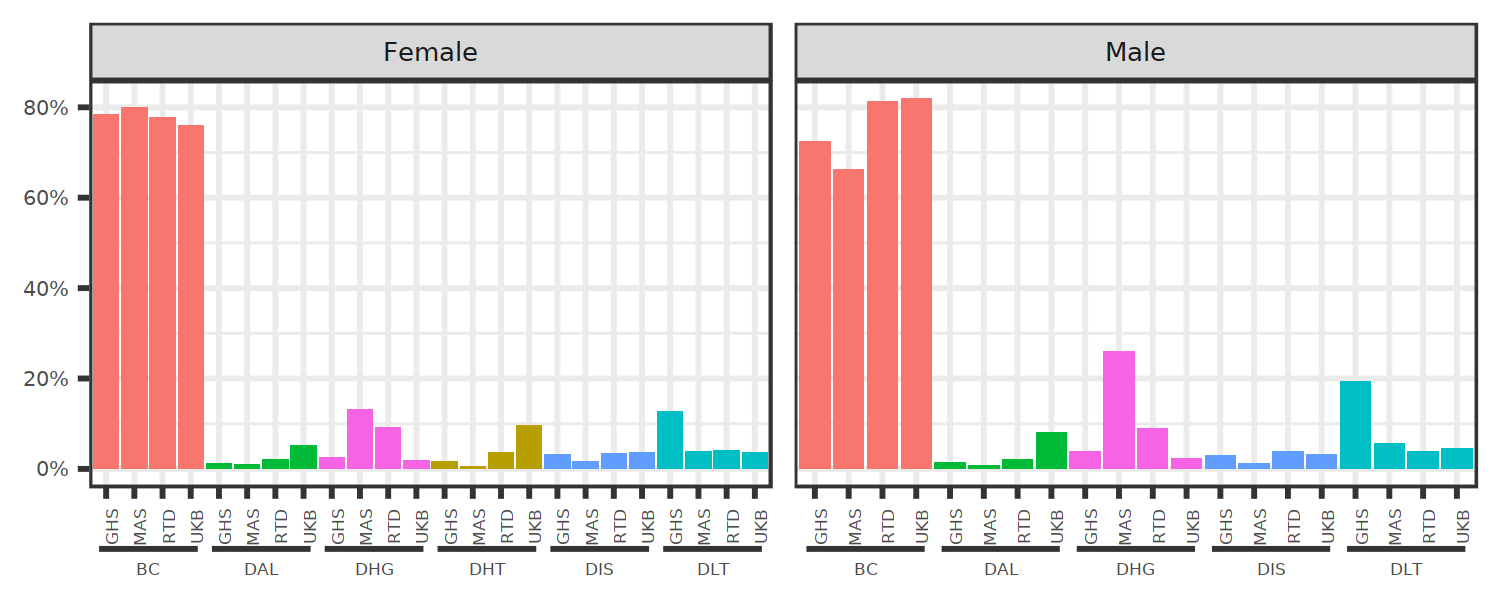

In [423]:
options(repr.plot.width = 5, repr.plot.height = 2)
propclusall %>%
    pivot_longer(-c(sex, cohort), names_to = "Cluster", values_to = "N", values_drop_na = TRUE) %>%
    group_by(sex, cohort) %>%
    inner_join(cluscolmap, by = "Cluster") %>%
    mutate(
        Nsum = sum(N),
        prop = N/Nsum,
        cohort = stringr::str_replace_all(
            cohort,
            c(
                "ukb" = "UKB",
                "maastricht" = "MAS",
                "rotterdam" = "RTD",
                "ghs" = "GHS"
            )
        )
    ) %>%
    ggplot(aes(interaction(cohort, Cluster), prop)) +
    geom_col(aes(fill = ClusCol)) +
    scale_fill_identity() +
    scale_x_discrete(guide = ggh4x::guide_axis_nested()) +
    scale_y_continuous(labels = scales::percent) +
    ggh4x::facet_nested(
        ~sex, 
        scales = "free",
        strip = ggh4x::strip_nested( 
            size = "variable"
        )
    ) +
    labs(x = NULL, y = NULL) + 
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 4, angle = 90),
        axis.text.y = element_text(size = 5),
        axis.title.x = element_text(size = 6),
        strip.text = element_text(size = 6),
        legend.position = "top"
    )

## Distribution of biomarkers

In [375]:
bm_meansd <- result_crosssect %>%
    filter(element_name == "MarkerDistrib") %>%
    unnest(element_value) %>%
    filter(Type == "Numeric") %>%
    mutate(
        Summary1 = gsub("\\(|\\)", "", Summary1),
        cohort = stringr::str_replace_all(
            cohort,
            c(
                "ukb" = "UKB",
                "maastricht" = "MAS",
                "rotterdam" = "RTD",
                "ghs" = "GHS"
            )
        )
    ) %>%
    separate_wider_delim(Summary1, delim = " ", names = c("Mean", "SD")) %>%
    transmute(cohort, sex, Variable, Cluster, across(c(N, Mean, SD), as.numeric))
head(bm_meansd)

cohort,sex,Variable,Cluster,N,Mean,SD
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
UKB,Female,whr,BC,58707.879,0.82,0.07
UKB,Female,whr,DHT,7483.777,0.79,0.05
UKB,Female,whr,DAL,3950.988,0.87,0.06
UKB,Female,whr,DLT,2835.984,0.84,0.07
UKB,Female,whr,DIS,2750.474,0.84,0.07
UKB,Female,whr,DHG,1477.897,0.85,0.08


In [377]:
bm_meansd %>%
    select(-N) %>%
    nest(D = -sex) %>%
    mutate(
        D = map(D, pivot_wider, names_from = Cluster, values_from = c(Mean, SD), names_vary = "slowest"),
        D = map2(D, sex, ~mutate(.x, sex = .y, .before = 1)),
        D = map(D, arrange, Variable)
    ) %>%
    pull(D)

sex,cohort,Variable,Mean_BC,SD_BC,Mean_DHT,SD_DHT,Mean_DAL,SD_DAL,Mean_DLT,SD_DLT,Mean_DIS,SD_DIS,Mean_DHG,SD_DHG
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,UKB,age,57.43,7.90,57.02,7.90,57.89,7.29,57.21,7.19,57.84,7.95,59.28,7.45
Female,MAS,age,58.10,8.12,60.54,6.11,58.17,6.19,58.86,7.16,52.91,9.43,62.11,8.13
Female,RTD,age,64.72,10.03,61.55,9.60,62.35,8.05,60.29,7.98,67.12,10.37,67.19,9.64
Female,GHS,age,54.57,11.17,52.34,10.85,54.51,10.38,54.55,10.08,53.69,11.91,62.88,9.04
Female,UKB,alt,18.87,7.34,16.58,4.71,22.13,8.11,48.71,17.04,18.94,7.80,22.01,10.64
Female,MAS,alt,23.83,7.92,19.21,3.75,26.05,4.82,53.84,14.69,20.89,7.17,28.95,12.33
Female,RTD,alt,21.11,7.36,18.97,4.54,22.98,7.14,52.11,17.54,19.53,7.22,24.87,10.69
Female,GHS,alt,28.13,6.70,23.40,4.01,28.21,6.98,53.74,28.99,27.48,8.38,32.91,10.85
Female,UKB,bmi,26.99,5.06,25.93,4.22,27.73,4.08,28.29,5.18,29.52,6.34,29.41,6.31


In [379]:
pooledmean <- bm_meansd %>%
    nest(D = -c(sex, Variable, Cluster)) %>%
    mutate(
        D = map(
            D,
            ~meta::metamean(n = .x$N, mean = .x$Mean, sd = .x$SD)
        ),
        D = map(
            D,
            ~tibble(
                N = sum(.x$n),
                Mean = .x$TE.fixed, 
                SD = sqrt(sum(.x$n)) * .x$seTE.fixed
            )
        )
    ) %>%
    unnest(D)
head(pooledmean)

sex,Variable,Cluster,N,Mean,SD
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Female,whr,BC,70112.749,0.8258278,0.07089216
Female,whr,DHT,7818.851,0.7905854,0.05000000
Female,whr,DAL,4181.259,0.8716331,0.05995454
Female,whr,DLT,4057.711,0.8510862,0.07047157
Female,whr,DIS,3206.325,0.8443558,0.07148628
Female,whr,DHG,2377.105,0.8713013,0.08146859


In [384]:
allmeansd <- pooledmean %>%
    mutate(cohort = "Pooled", .before = 1) %>%
    bind_rows(bm_meansd)
head(allmeansd)

cohort,sex,Variable,Cluster,N,Mean,SD
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
Pooled,Female,whr,BC,70112.749,0.8258278,0.07089216
Pooled,Female,whr,DHT,7818.851,0.7905854,0.05000000
Pooled,Female,whr,DAL,4181.259,0.8716331,0.05995454
Pooled,Female,whr,DLT,4057.711,0.8510862,0.07047157
Pooled,Female,whr,DIS,3206.325,0.8443558,0.07148628
Pooled,Female,whr,DHG,2377.105,0.8713013,0.08146859


In [385]:
write_tsv(allmeansd, "../data/allmeansd.tsv")

In [382]:
pooledmean %>%
    select(-N) %>%
    nest(D = -sex) %>%
    mutate(
        D = map(
            D, 
            pivot_wider, 
            names_from = Cluster, 
            values_from = c(Mean, SD), 
            names_vary = "slowest"
        ),
        D = map(D, arrange, Variable)
    ) %>%
    pull(D)

Variable,Mean_BC,SD_BC,Mean_DHT,SD_DHT,Mean_DAL,SD_DAL,Mean_DLT,SD_DLT,Mean_DIS,SD_DIS,Mean_DHG,SD_DHG
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,57.6232253,8.17365420,57.0680019,7.9604813,57.9603242,7.34669897,57.0469822,7.67838297,58.0128606,8.23633341,60.8982657,7.96712435
alt,19.9796451,7.29080509,16.7971985,4.6900352,22.3806848,8.01968124,49.5132836,18.46102344,19.5514719,7.79463678,23.9117443,10.78414479
bmi,26.9289164,5.01677948,25.9379160,4.2292904,27.6821749,4.06346560,28.0133852,5.11798686,29.4116525,6.33509034,29.6954663,5.89968044
crp,2.1742617,2.27244010,1.4134418,1.2038804,2.3368448,1.82086640,2.5631740,2.42527007,13.6956183,5.44034974,2.9002942,2.98125765
dbp,79.6382389,9.12235679,92.7186823,8.5005340,83.2326689,9.85667292,83.0015327,10.28711341,81.8759069,10.33670954,78.8722066,10.38146019
fg,4.9535341,0.49659823,4.9461082,0.3816353,4.9466267,0.48942301,5.0106362,0.53135557,4.9721767,0.57837082,7.4114590,1.36383254
hdl,1.6422700,0.38359424,1.6905404,0.3208438,1.2758231,0.21986550,1.5441516,0.36834241,1.4825683,0.36102796,1.4148146,0.36929914
ldl,3.6472407,0.86952105,3.5389144,0.7307309,4.4232444,0.91626434,3.7398758,0.96266405,3.5519750,0.81214254,3.2232805,0.90016399
sbp,133.8885407,17.99128177,159.0379926,18.5099449,139.4278215,18.48497435,136.4421727,19.09756181,137.0621810,18.92006746,139.2753023,19.22171392


In [394]:
bm_iqr <- result_crosssect %>%
    filter(element_name == "MarkerDistrib") %>%
    unnest(element_value) %>%
    filter(Type == "Numeric") %>%
    mutate(
        Summary2 = stringr::str_replace_all(
            Summary2,
            c(
                "\\(" = "- ",
                "\\)" = ""
            )
        ),
        cohort = stringr::str_replace_all(
            cohort,
            c(
                "ukb" = "UKB",
                "maastricht" = "MAS",
                "rotterdam" = "RTD",
                "ghs" = "GHS"
            )
        )
    ) %>%
    separate_wider_delim(
        Summary2, 
        delim = " - ", 
        names = paste(
            "calc",
            c(
                "Median",
                "minval",
                "p25",
                "p75",
                "maxval"
            ),
            sep = "_"
        )
    ) %>%
    transmute(
        cohort, sex, Variable, Cluster, N,
        across(starts_with("calc"), as.numeric)
    ) %>%
    rename_with(\(x) gsub("calc_", "", x), starts_with("calc"))
head(bm_iqr)

cohort,sex,Variable,Cluster,N,Median,minval,p25,p75,maxval
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UKB,Female,whr,BC,58707.879,0.81,0.70,0.77,0.86,0.96
UKB,Female,whr,DHT,7483.777,0.78,0.69,0.75,0.82,0.90
UKB,Female,whr,DAL,3950.988,0.86,0.76,0.83,0.91,0.99
UKB,Female,whr,DLT,2835.984,0.84,0.71,0.79,0.89,0.98
UKB,Female,whr,DIS,2750.474,0.83,0.71,0.79,0.89,0.98
UKB,Female,whr,DHG,1477.897,0.85,0.71,0.79,0.91,1.02


In [425]:
write_tsv(bm_iqr, "../data/bm_iqr.tsv")

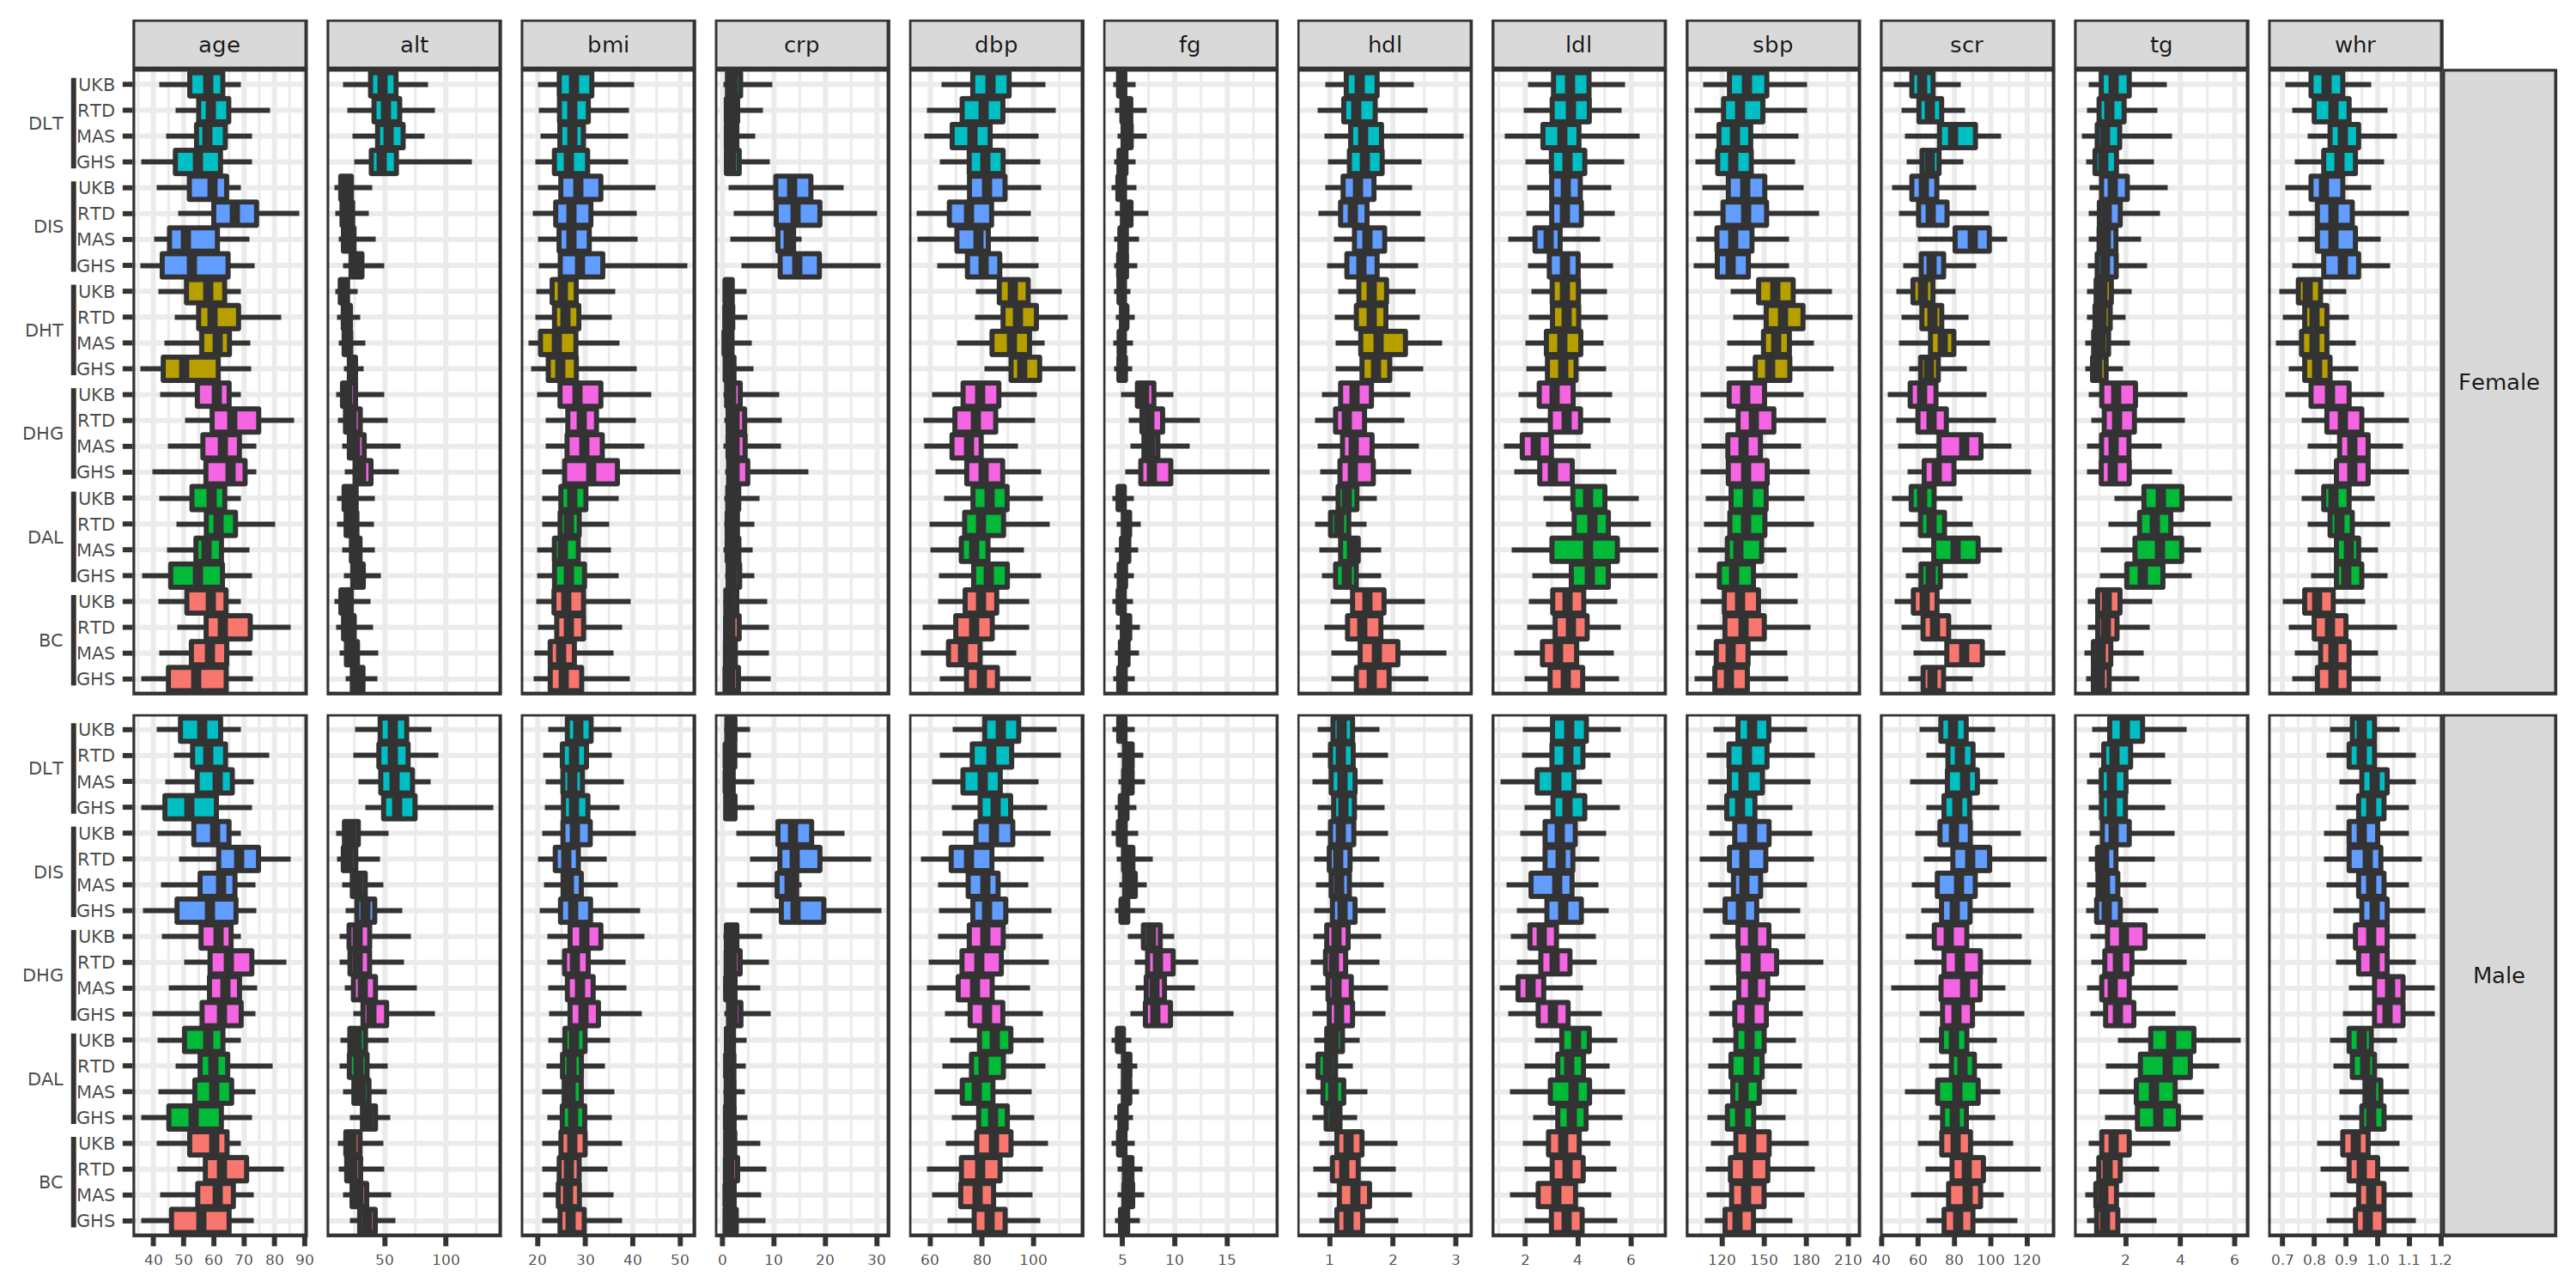

In [424]:
options(repr.plot.width = 10, repr.plot.height = 5)
bm_iqr %>%
    inner_join(cluscolmap, by = "Cluster") %>%
    ggplot(aes(y = interaction(cohort, Cluster))) +
    geom_boxplot(
        aes(
            xmin = minval,
            xlower = p25,
            xmiddle = Median,
            xupper = p75,
            xmax = maxval,
            fill = ClusCol
        ),
        stat = "identity",
        size = .5
    ) +
    scale_fill_identity() +
    scale_y_discrete(guide = ggh4x::guide_axis_nested()) +
    ggh4x::facet_nested(
        sex ~ Variable, 
        scales = "free",
        space = "free_y",
        strip = ggh4x::strip_nested(
            text_y = ggh4x::elem_list_text(angle = 0), 
            size = "variable"
        )
    ) +
    labs(x = NULL, y = NULL) + 
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 4),
        axis.text.y = element_text(size = 5),
        axis.title.x = element_text(size = 6),
        strip.text = element_text(size = 6)
    )

Prevalence of smoking:

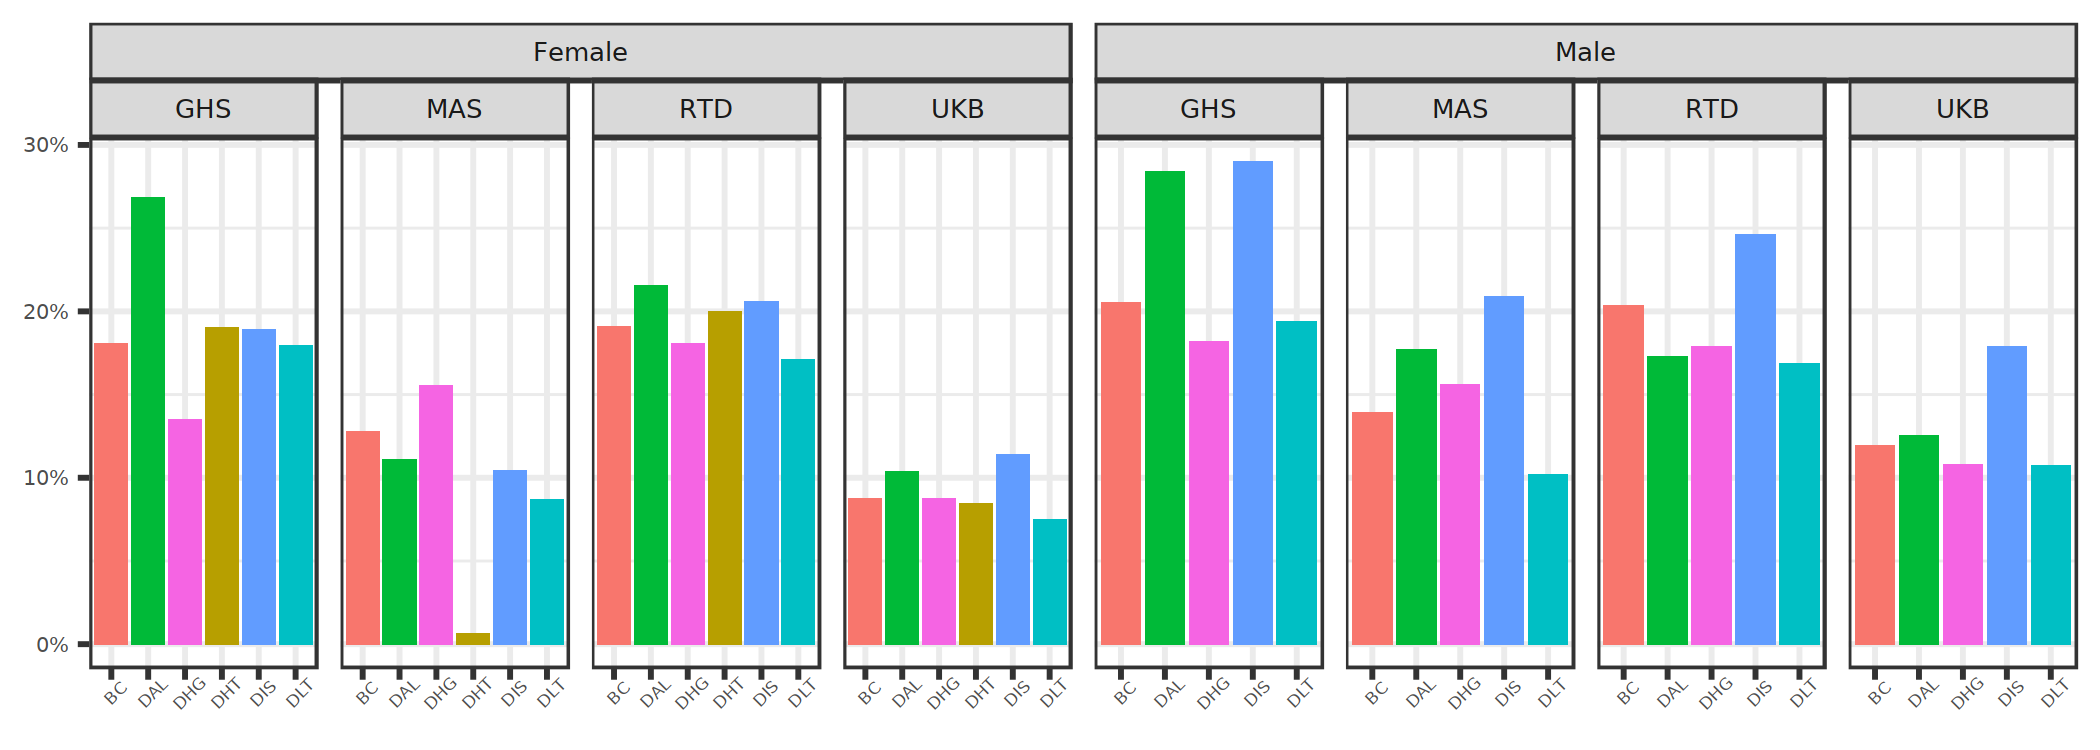

In [426]:
options(repr.plot.width = 7, repr.plot.height = 2.5)
result_crosssect %>%
    filter(element_name == "MarkerDistrib") %>%
    unnest(element_value) %>%
    filter(Variable == "smoking", Summary1 == 1) %>%
    mutate(
        cohort = stringr::str_replace_all(
            cohort,
            c(
                "ukb" = "UKB",
                "maastricht" = "MAS",
                "rotterdam" = "RTD",
                "ghs" = "GHS"
            )
        ),
        prop = as.numeric(Summary2)/N
    ) %>%
    inner_join(cluscolmap, by = "Cluster") %>%
    ggplot(aes(Cluster, prop)) +
    geom_col(aes(fill = ClusCol)) +
    scale_fill_identity() +
    scale_y_continuous(labels = scales::percent) +
    ggh4x::facet_nested(
        ~sex + cohort, 
        scales = "free",
        strip = ggh4x::strip_nested( 
            size = "variable"
        )
    ) +
    labs(x = NULL, y = NULL) + 
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 4, angle = 45, hjust = 0.5),
        axis.text.y = element_text(size = 5),
        axis.title.x = element_text(size = 6),
        strip.text = element_text(size = 6),
        legend.position = "top"
    )

## BMI effects by cluster

In [10]:
bmieffdf <- result_crosssect %>%
    filter(element_name == "BMIeffOnMarker") %>%
    unnest(element_value) %>%
    filter(term == "bmi") %>%
    select(-c(element_name, term))
head(bmieffdf)

cohort,sex,Variable,Cluster,estimate,se
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
ukb,Female,whr,BC,0.006069039,4.309974e-05
ukb,Female,whr,DHT,0.005896261,3.913097e-05
ukb,Female,whr,DAL,0.005768352,4.869614e-05
ukb,Female,whr,DLT,0.006668289,4.263331e-05
ukb,Female,whr,DIS,0.004804825,3.615461e-05
ukb,Female,whr,DHG,0.005573564,4.042542e-05


In [11]:
pooledBMIEff <- bmieffdf %>%
    nest(D = -c(sex, Variable, Cluster)) %>%
    mutate(
        D = map(
            D,
            ~meta::metagen(TE = .x$estimate, seTE = .x$se)
        ),
        D = map(
            D,
            ~tibble(
                cohort = c("Pooled_FE", "Pooled_RE"),
                estimate = c(.x$TE.fixed, .x$TE.random), 
                se = c(.x$seTE.fixed, .x$seTE.random)
            )
        )
    ) %>%
    unnest(D)
head(pooledBMIEff)

sex,Variable,Cluster,cohort,estimate,se
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Female,whr,BC,Pooled_FE,0.006012873,4.042772e-05
Female,whr,BC,Pooled_RE,0.005976569,2.953433e-04
Female,whr,DHT,Pooled_FE,0.005631700,3.540392e-05
Female,whr,DHT,Pooled_RE,0.005017700,3.929276e-04
Female,whr,DAL,Pooled_FE,0.005656986,4.449228e-05
Female,whr,DAL,Pooled_RE,0.004565761,1.113615e-03


In [12]:
allbmieff <- pooledBMIEff %>%
    bind_rows(bmieffdf) %>%
    mutate(
        cohort = stringr::str_replace_all(
            cohort,
            c(
                "ukb" = "UKB",
                "maastricht" = "MAS",
                "rotterdam" = "RTD",
                "ghs" = "GHS"
            )
        ),
        pval = 2 * pnorm(-abs(estimate/se)),
        lwr = estimate - qnorm(.975)*se,
        upr = estimate + qnorm(.975)*se
    )
head(allbmieff)

sex,Variable,Cluster,cohort,estimate,se,pval,lwr,upr
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,whr,BC,Pooled_FE,0.006012873,4.042772e-05,0.000000e+00,0.005933636,0.006092110
Female,whr,BC,Pooled_RE,0.005976569,2.953433e-04,4.718667e-91,0.005397707,0.006555431
Female,whr,DHT,Pooled_FE,0.005631700,3.540392e-05,0.000000e+00,0.005562310,0.005701091
Female,whr,DHT,Pooled_RE,0.005017700,3.929276e-04,2.410420e-37,0.004247576,0.005787824
Female,whr,DAL,Pooled_FE,0.005656986,4.449228e-05,0.000000e+00,0.005569783,0.005744189
Female,whr,DAL,Pooled_RE,0.004565761,1.113615e-03,4.132462e-05,0.002383116,0.006748406


In [13]:
write_tsv(allbmieff, "../data/allbmieff.tsv")

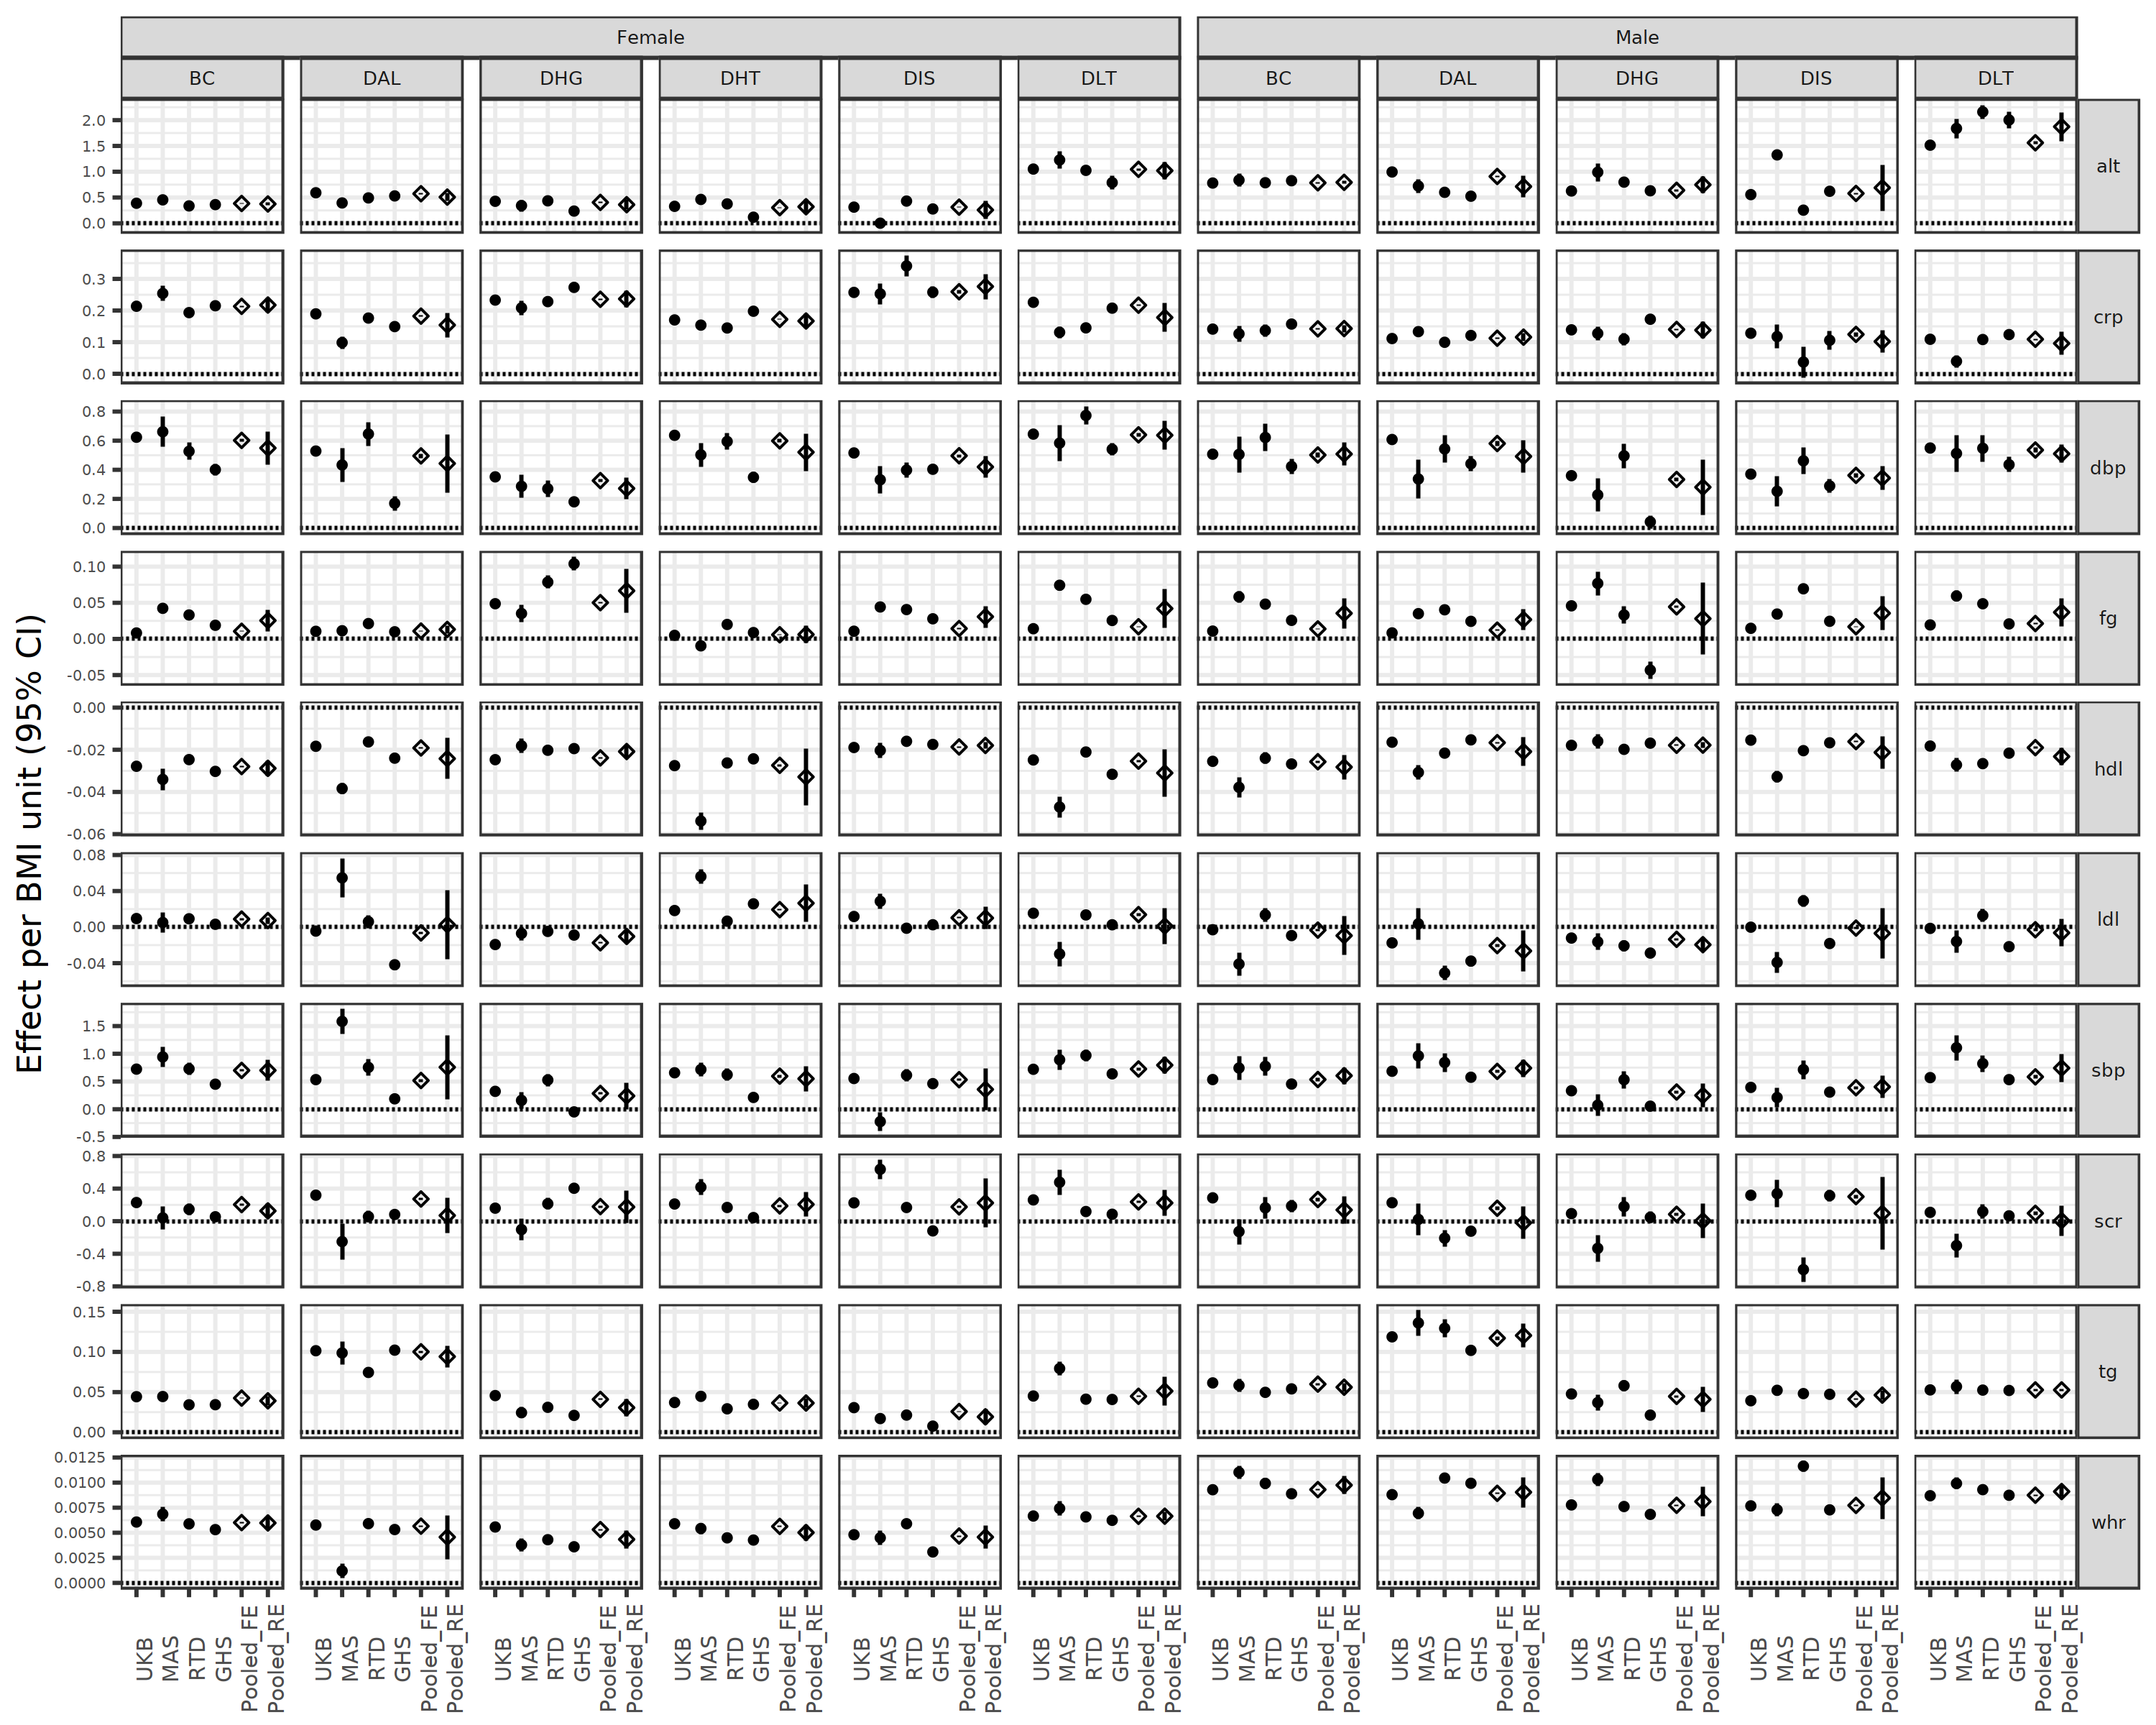

In [38]:
options(repr.plot.width = 10, repr.plot.height = 8)
allbmieff %>%
    mutate(
        cohort = factor(
            cohort,
            levels = c("UKB", "MAS", "RTD", "GHS", "Pooled_FE", "Pooled_RE")
        )
    ) %>%
    ggplot(aes(cohort, estimate)) +
    geom_hline(yintercept = 0, lty = "dashed") +
    geom_linerange(
        aes(
            ymin = lwr,
            ymax = upr
        )
    ) +
    geom_point(
        aes(shape = grepl("Pooled", cohort)),
        show.legend = FALSE
    ) +
    scale_shape_manual(
        values = c(20, 23)
    ) +
    ggh4x::facet_nested(
        Variable ~ sex + Cluster, 
        scales = "free",
        strip = ggh4x::strip_nested(
            text_y = ggh4x::elem_list_text(angle = 0), 
            size = "variable"
        )
    ) +
    labs(y = "Effect per BMI unit (95% CI)", x = NULL) + 
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 7, angle = 90),
        axis.text.y = element_text(size = 5),
        axis.title.x = element_text(size = 6),
        strip.text = element_text(size = 6)
    )

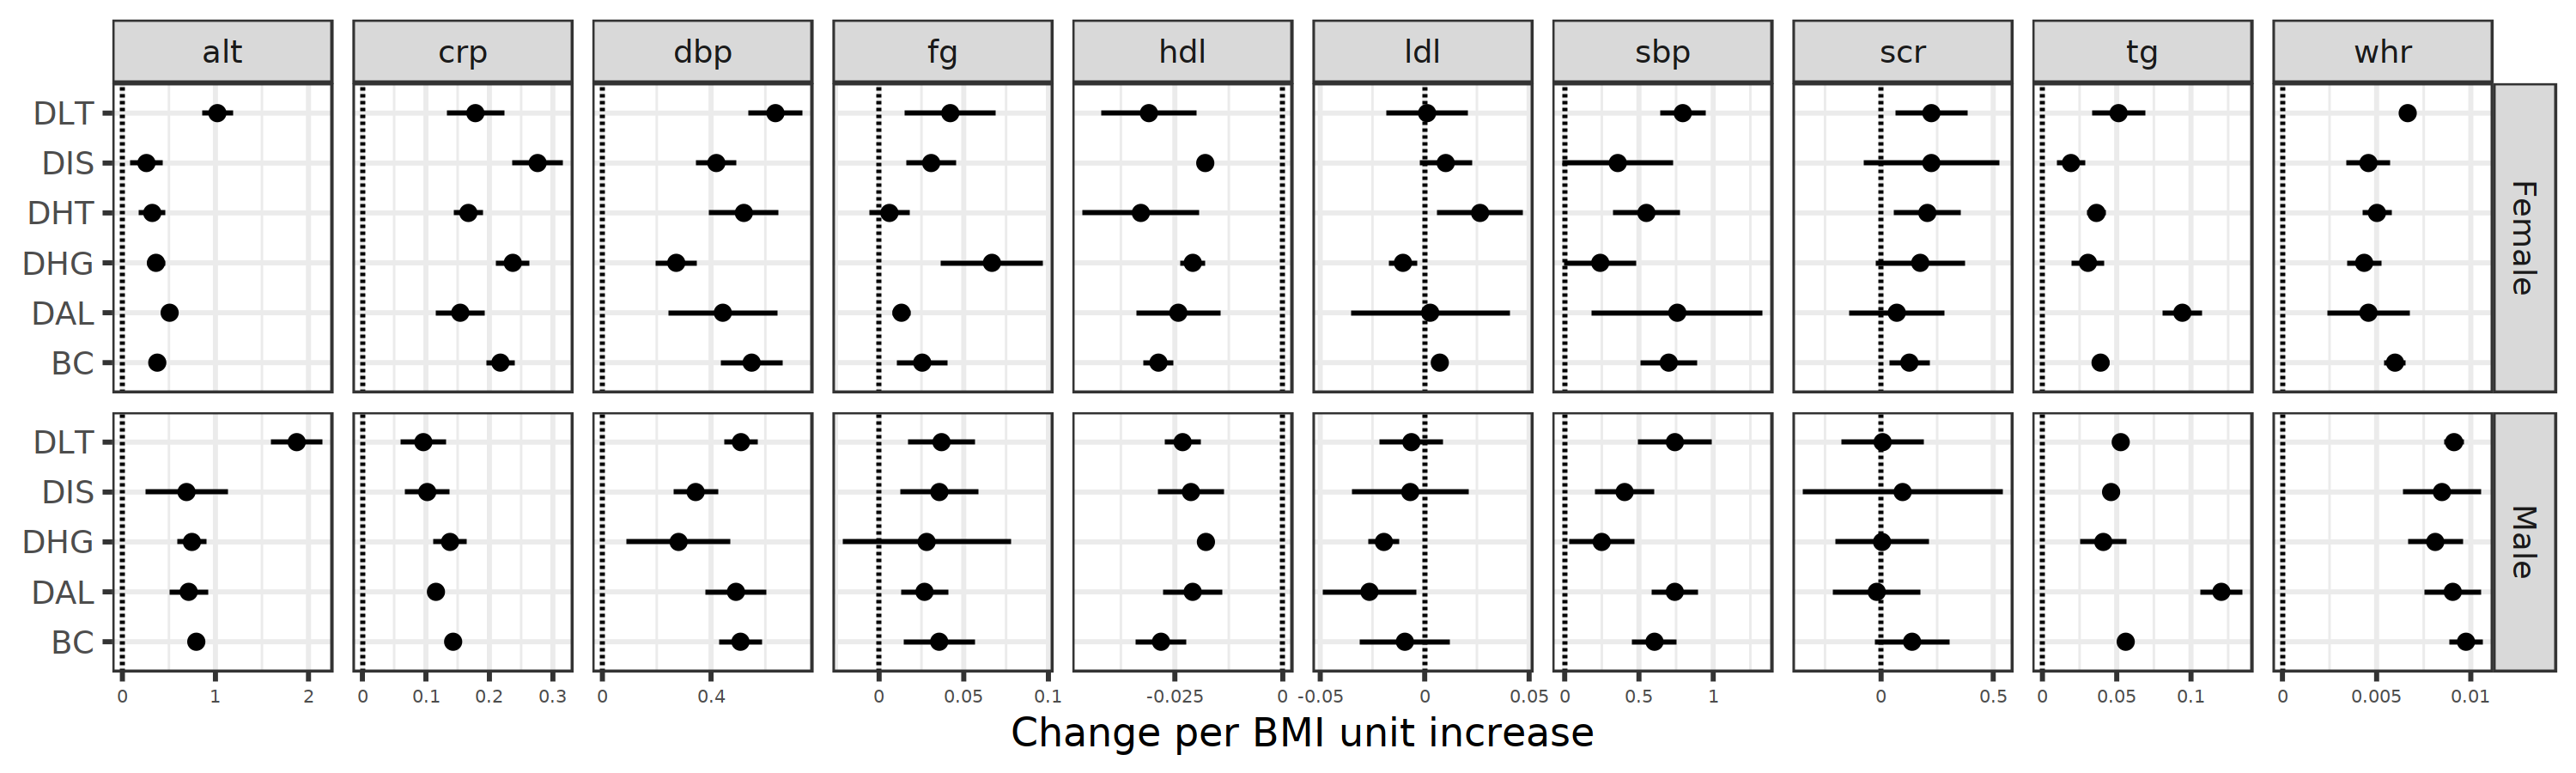

In [74]:
options(repr.plot.width = 10, repr.plot.height = 3)
allbmieff %>%
    filter(cohort == "Pooled_RE") %>%
    ggplot(aes(estimate, Cluster)) +
    geom_vline(xintercept = 0, lty = "dashed") +
    geom_linerange(aes(xmin = lwr, xmax = upr)) +
    geom_point() +
    scale_x_continuous(n.breaks = 3, labels = function(x) ifelse(x == 0, "0", x)) +
    facet_grid(sex ~ Variable, scales = "free", space = "free_y") +
    labs(x = "Change per BMI unit increase", y = NULL) +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

## ORs of diseases relative to concordant cluster

In [16]:
percohortORs <- result_crosssect %>%
    filter(element_name == "CountCovars") %>%
    unnest(element_value) %>%
    filter(
        Covariate %in% c(
            "CHD", "Stroke", "T2D", "HT", "T1D", "LiverFailure", "RA"
        ),
        !(cohort %in% c("maastricht", "rotterdam") & 
          Covariate %in% c("LiverFailure", "RA", "T1D")),
        !(cohort == "ghs" & Covariate == "RA")
    ) %>%
    select(-c(element_name, Nclus)) %>%
    nest(D = -c(sex, cohort, Covariate)) %>%
    mutate(
        Covariate = factor(
            Covariate,
            levels = c(
                "CHD", "Stroke", "T2D", "HT", "T1D", "LiverFailure", "RA"
            )
        ),
        mod = map(
            D, 
            ~glm(
                cbind(round(Ncases), round(Nnoncases)) ~ Cluster, 
                data = .x, family = "binomial"
            )
        )
    ) %>%
    mutate(
        mod = map(mod, broom::tidy),
        mod = map(mod, mutate, term = gsub("Cluster", "", term)),
        D = map2(D, mod, left_join, by = c("Cluster" = "term")),
        mod = NULL
    ) %>%
    unnest(D) %>%
    arrange(sex, cohort, Covariate)
head(percohortORs)

cohort,sex,Covariate,Cluster,Ncases,Nnoncases,estimate,std.error,statistic,p.value
<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ghs,Female,CHD,probBC,98.14408698,5634.50484,NA,NA,NA,NA
ghs,Female,CHD,probDHT,0.03017466,122.60273,-23.4639972,5.162694e+04,-0.0004544914,9.996374e-01
ghs,Female,CHD,probDAL,2.93988211,92.01067,0.6286087,5.954699e-01,1.0556513828,2.911275e-01
ghs,Female,CHD,probDLT,25.35624135,904.62162,0.4627258,2.269064e-01,2.0392806032,4.142203e-02
ghs,Female,CHD,probDIS,5.71842286,234.22531,0.3882233,4.258189e-01,0.9117099402,3.619214e-01
ghs,Female,CHD,probDHG,21.81119204,159.03483,2.0739232,2.492497e-01,8.3206658060,8.747056e-17


In [21]:
pooledORs <- result_crosssect %>%
    filter(element_name == "CountCovars") %>%
    unnest(element_value) %>%
    filter(
        Covariate %in% c(
            "CHD", "Stroke", "T2D", "HT", "T1D", "LiverFailure", "RA"
        ),
        !(cohort %in% c("maastricht", "rotterdam") & Covariate %in% c("LiverFailure", "RA")),
        !(cohort == "ghs" & Covariate == "RA")
    ) %>%
    select(-c(element_name, Nclus)) %>%
    nest(D = -c(sex, Covariate)) %>%
    mutate(
        Covariate = factor(
            Covariate,
            levels = c(
                "CHD", "Stroke", "T2D", "HT", "T1D", "LiverFailure", "RA"
            )
        ),
        Pooled_FE = map(
            D,
            ~if(length(unique(.x$cohort)) > 1){
                glm(
                    cbind(round(Ncases), round(Nnoncases)) ~ Cluster, 
                    data = .x, family = binomial
                )
            } else {
                NULL
            }                
        ),
        Pooled_RE = map(
            D,
            ~if(length(unique(.x$cohort)) > 1){
                glmer(
                    cbind(round(Ncases), round(Nnoncases)) ~ Cluster + (1|cohort), 
                    data = .x, family = binomial
                )
            } else {
                NULL
            }                
        )
    ) %>%
    pivot_longer(c(Pooled_FE, Pooled_RE), names_to = "cohort", values_to = "mod") %>%
    filter(!map_lgl(mod, is.null)) %>%
    mutate(
        mod = map2(cohort, mod, ~if(.x == "Pooled_FE"){ broom::tidy(.y) } else { broom.mixed::tidy(.y) }),
        mod = map(mod, mutate, term = gsub("Cluster", "", term)),
        D = map(D, group_by, Cluster),
        D = map(D, summarise, across(c(Ncases, Nnoncases), sum)),
        D = map2(D, mod, left_join, by = c("Cluster" = "term")),
        mod = NULL
    ) %>%
    unnest(D) %>%
    select(-c(effect, group)) %>%
    arrange(sex, Covariate)
head(pooledORs)

sex,Covariate,Cluster,Ncases,Nnoncases,estimate,std.error,statistic,p.value,cohort
<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Female,CHD,probBC,1906.62264,68142.395,NA,NA,NA,NA,Pooled_FE
Female,CHD,probDAL,92.70177,4087.281,-0.2063654,0.10740903,-1.921304,5.469345e-02,Pooled_FE
Female,CHD,probDHG,192.38304,2167.131,1.1529980,0.07879806,14.632314,1.747415e-48,Pooled_FE
Female,CHD,probDHT,104.39509,7711.927,-0.7199709,0.10095946,-7.131287,9.943471e-13,Pooled_FE
Female,CHD,probDIS,130.33341,3071.588,0.4143776,0.09250551,4.479491,7.482130e-06,Pooled_FE
Female,CHD,probDLT,126.56405,3928.678,0.1364888,0.09343605,1.460773,1.440778e-01,Pooled_FE


In [22]:
allORs <- pooledORs %>%
    bind_rows(percohortORs) %>%
    transmute(
        sex, Covariate, 
        cohort = factor(
            case_match(
                cohort,
                "ukb" ~ "UKB",
                "maastricht" ~ "MAS",
                "rotterdam" ~ "RTD",
                "ghs" ~ "GHS",
                .default = cohort
            ),
            levels = c("UKB", "MAS", "RTD", "GHS", "Pooled_FE", "Pooled_RE")
        ),      
        Cluster = gsub("prob", "", Cluster), 
        across(everything()),
        OR = exp(estimate),
        LOWERCI = exp(estimate - qnorm(1 - .05/2)*std.error),
        UPPERCI = exp(estimate + qnorm(1 - .05/2)*std.error)
    ) %>%
    arrange(sex, Covariate, Cluster, cohort)
head(allORs)
nrow(allORs)

sex,Covariate,cohort,Cluster,Ncases,Nnoncases,estimate,std.error,statistic,p.value,OR,LOWERCI,UPPERCI
<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,CHD,UKB,BC,1659.00050,57014.334,NA,NA,NA,NA,NA,NA,NA
Female,CHD,MAS,BC,16.49118,1216.958,NA,NA,NA,NA,NA,NA,NA
Female,CHD,RTD,BC,132.98687,4276.599,NA,NA,NA,NA,NA,NA,NA
Female,CHD,GHS,BC,98.14409,5634.505,NA,NA,NA,NA,NA,NA,NA
Female,CHD,Pooled_FE,BC,1906.62264,68142.395,NA,NA,NA,NA,NA,NA,NA
Female,CHD,Pooled_RE,BC,1906.62264,68142.395,NA,NA,NA,NA,NA,NA,NA


[1] 363

In [23]:
write_tsv(allORs, "../data/allORs.tsv")

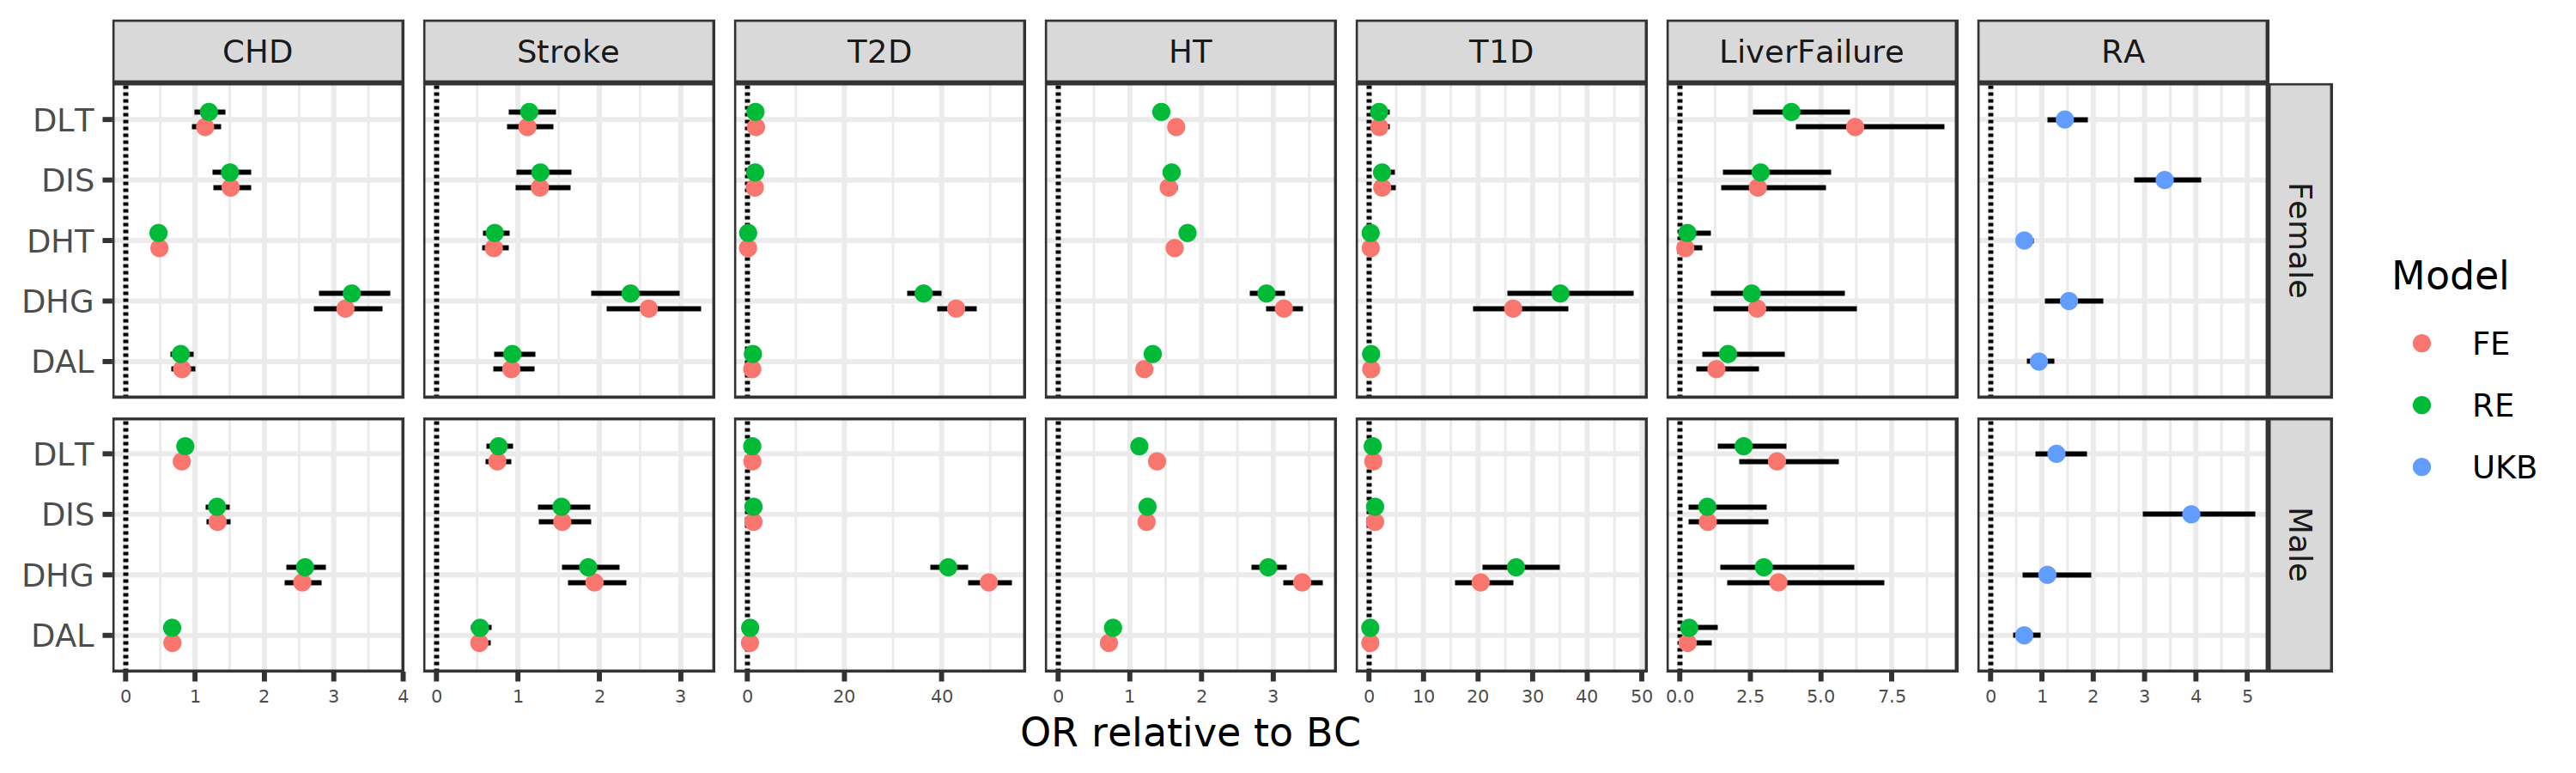

In [77]:
options(repr.plot.width = 10, repr.plot.height = 3)
allORs %>%
    drop_na %>%
    filter(cohort %in% c("Pooled_FE", "Pooled_RE") | Covariate == "RA") %>%
    mutate(cohort = gsub("Pooled_", "", cohort)) %>%
    ggplot(aes(OR, Cluster)) +
    geom_vline(xintercept = 0, lty = "dashed") +
    geom_linerange(
        aes(xmin = LOWERCI, xmax = UPPERCI, group = cohort),
        position = position_dodge(width = .5)
    ) +
    geom_point(
        aes(group = cohort, color = cohort),
        position = position_dodge(width = .5)
    ) +
    facet_grid(sex ~ Covariate, scales = "free", space = "free_y") +
    labs(x = "OR relative to BC", y = NULL, color = "Model") +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

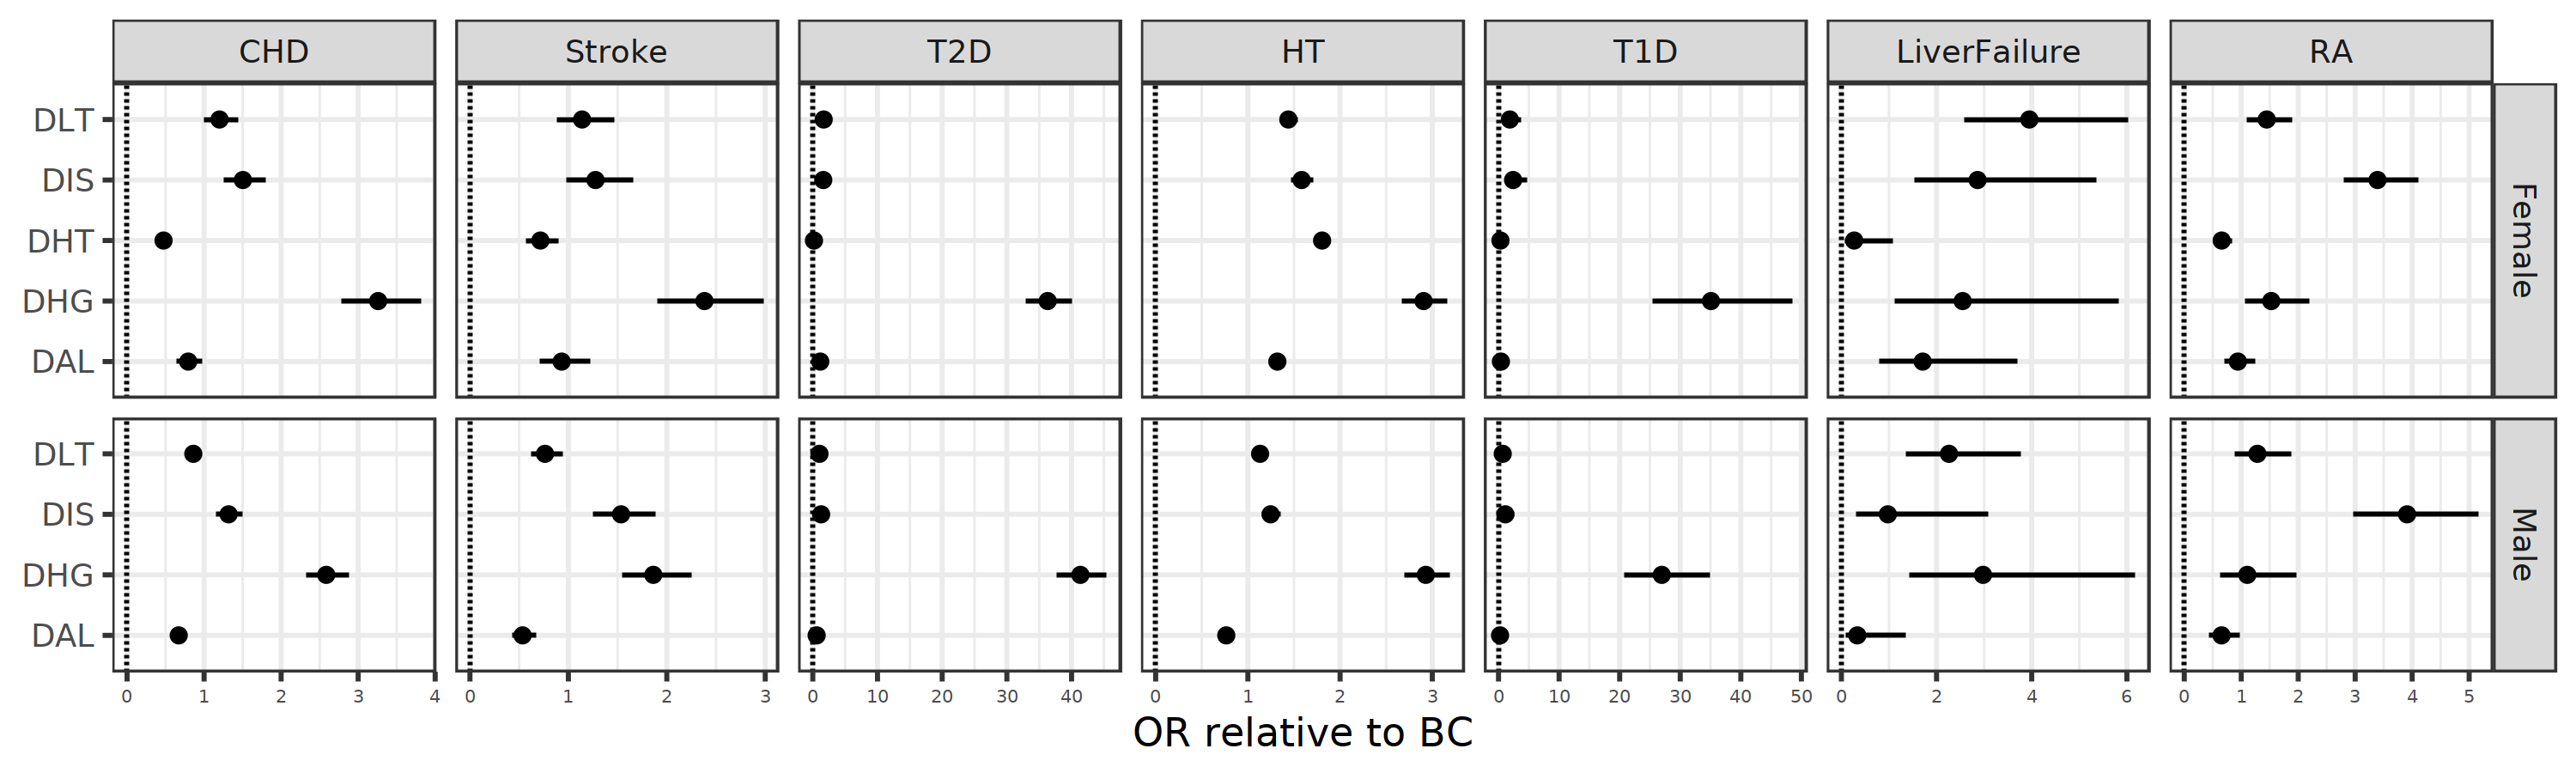

In [78]:
options(repr.plot.width = 10, repr.plot.height = 3)
allORs %>%
    drop_na %>%
    filter(cohort == "Pooled_RE" | Covariate == "RA") %>%
    ggplot(aes(OR, Cluster)) +
    geom_vline(xintercept = 0, lty = "dashed") +
    geom_linerange(
        aes(xmin = LOWERCI, xmax = UPPERCI)
    ) +
    geom_point() +
    facet_grid(sex ~ Covariate, scales = "free", space = "free_y") +
    labs(x = "OR relative to BC", y = NULL, color = "Model") +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

## ORs of medications relative to concordant cluster

In [24]:
percohortORmeds <- result_crosssect %>%
    filter(element_name == "CountCovars") %>%
    unnest(element_value) %>%
    filter(
        Covariate %in% c(
            "Insulin", "AntiHT", "LipidLower"
        ),
        !(cohort %in% c("maastricht", "rotterdam") & Covariate == "Insulin")
    ) %>%
    select(-c(element_name, Nclus)) %>%
    nest(D = -c(sex, cohort, Covariate)) %>%
    mutate(
        Covariate = factor(
            Covariate,
            levels = c(
                "Insulin", "AntiHT", "LipidLower"
            )
        ),
        mod = map(
            D, 
            ~glm(
                cbind(round(Ncases), round(Nnoncases)) ~ Cluster, 
                data = .x, family = "binomial"
            )
        )
    ) %>%
    mutate(
        mod = map(mod, broom::tidy),
        mod = map(mod, mutate, term = gsub("Cluster", "", term)),
        D = map2(D, mod, left_join, by = c("Cluster" = "term")),
        mod = NULL
    ) %>%
    unnest(D) %>%
    arrange(sex, cohort, Covariate)
head(percohortORmeds)

cohort,sex,Covariate,Cluster,Ncases,Nnoncases,estimate,std.error,statistic,p.value
<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ghs,Female,Insulin,probBC,32.34996392,5700.2990,NA,NA,NA,NA
ghs,Female,Insulin,probDHT,0.08283218,122.5501,-22.3332966,5.162694e+04,-0.0004325900,9.996548e-01
ghs,Female,Insulin,probDAL,0.22865167,94.7219,-22.0780521,5.170607e+04,-0.0004269915,9.996593e-01
ghs,Female,Insulin,probDLT,7.19815545,922.7797,0.3007665,4.187672e-01,0.7182186991,4.726225e-01
ghs,Female,Insulin,probDIS,3.63506086,236.3087,1.1049481,5.344743e-01,2.0673551657,3.870070e-02
ghs,Female,Insulin,probDHG,64.50533592,116.3407,4.6032826,2.354373e-01,19.5520494884,3.962768e-85


In [25]:
pooledORmeds <- result_crosssect %>%
    filter(element_name == "CountCovars") %>%
    unnest(element_value) %>%
    filter(
        Covariate %in% c(
            "Insulin", "AntiHT", "LipidLower"
        ),
        !(cohort %in% c("maastricht", "rotterdam") & Covariate == "Insulin")
    ) %>%
    select(-c(element_name, Nclus)) %>%
    nest(D = -c(sex, Covariate)) %>%
    mutate(
        Covariate = factor(
            Covariate,
            levels = c(
                "Insulin", "AntiHT", "LipidLower"
            )
        ),
        Pooled_FE = map(
            D,
            ~if(length(unique(.x$cohort)) > 1){
                glm(
                    cbind(round(Ncases), round(Nnoncases)) ~ Cluster, 
                    data = .x, family = binomial
                )
            } else {
                NULL
            }                
        ),
        Pooled_RE = map(
            D,
            ~if(length(unique(.x$cohort)) > 1){
                glmer(
                    cbind(round(Ncases), round(Nnoncases)) ~ Cluster + (1|cohort), 
                    data = .x, family = binomial
                )
            } else {
                NULL
            }                
        )
    ) %>%
    pivot_longer(c(Pooled_FE, Pooled_RE), names_to = "cohort", values_to = "mod") %>%
    filter(!map_lgl(mod, is.null)) %>%
    mutate(
        mod = map2(cohort, mod, ~if(.x == "Pooled_FE"){ broom::tidy(.y) } else { broom.mixed::tidy(.y) }),
        mod = map(mod, mutate, term = gsub("Cluster", "", term)),
        D = map(D, group_by, Cluster),
        D = map(D, summarise, across(c(Ncases, Nnoncases), sum)),
        D = map2(D, mod, left_join, by = c("Cluster" = "term")),
        mod = NULL
    ) %>%
    unnest(D) %>%
    select(-c(effect, group)) %>%
    arrange(sex, Covariate)
head(pooledORmeds)

sex,Covariate,Cluster,Ncases,Nnoncases,estimate,std.error,statistic,p.value,cohort
<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Female,Insulin,probBC,186.58220,64219.401,NA,NA,NA,NA,Pooled_FE
Female,Insulin,probDAL,11.09235,4034.390,-0.06055859,0.3107231,-0.1948957,8.454746e-01,Pooled_FE
Female,Insulin,probDHG,202.73178,1440.848,3.88442111,0.1049378,37.0164072,6.236655e-300,Pooled_FE
Female,Insulin,probDHT,3.45699,7601.307,-1.99324663,0.5820749,-3.4243819,6.161996e-04,Pooled_FE
Female,Insulin,probDIS,15.93828,2970.426,0.62057921,0.2611995,2.3758824,1.750704e-02,Pooled_FE
Female,Insulin,probDLT,18.19840,3747.627,0.50570184,0.2474151,2.0439410,4.095938e-02,Pooled_FE


In [28]:
allORmeds <- pooledORmeds %>%
    bind_rows(percohortORmeds) %>%
    transmute(
        sex, Covariate, 
        cohort = factor(
            case_match(
                cohort,
                "ukb" ~ "UKB",
                "maastricht" ~ "MAS",
                "rotterdam" ~ "RTD",
                "ghs" ~ "GHS",
                .default = cohort
            ),
            levels = c("UKB", "MAS", "RTD", "GHS", "Pooled_FE", "Pooled_RE")
        ),       
        Cluster = gsub("prob", "", Cluster), 
        across(everything()),
        OR = exp(estimate),
        LOWERCI = exp(estimate - qnorm(1 - .05/2)*std.error),
        UPPERCI = exp(estimate + qnorm(1 - .05/2)*std.error)
    ) %>%
    arrange(sex, Covariate, Cluster, cohort)
head(allORmeds)
nrow(allORmeds)

sex,Covariate,cohort,Cluster,Ncases,Nnoncases,estimate,std.error,statistic,p.value,OR,LOWERCI,UPPERCI
<chr>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,Insulin,UKB,BC,154.2322367,58519.1024,NA,NA,NA,NA,NA,NA,NA
Female,Insulin,GHS,BC,32.3499639,5700.2990,NA,NA,NA,NA,NA,NA,NA
Female,Insulin,Pooled_FE,BC,186.5822006,64219.4014,NA,NA,NA,NA,NA,NA,NA
Female,Insulin,Pooled_RE,BC,186.5822006,64219.4014,NA,NA,NA,NA,NA,NA,NA
Female,Insulin,UKB,DAL,10.8636938,3939.6678,0.05911343,3.125276e-01,0.1891462938,0.8499782,1.060896e+00,0.5749746,1.957477
Female,Insulin,GHS,DAL,0.2286517,94.7219,-22.07805210,5.170607e+04,-0.0004269915,0.9996593,2.580024e-10,0.0000000,Inf


[1] 176

In [29]:
write_tsv(allORmeds, "../data/allORmeds.tsv")

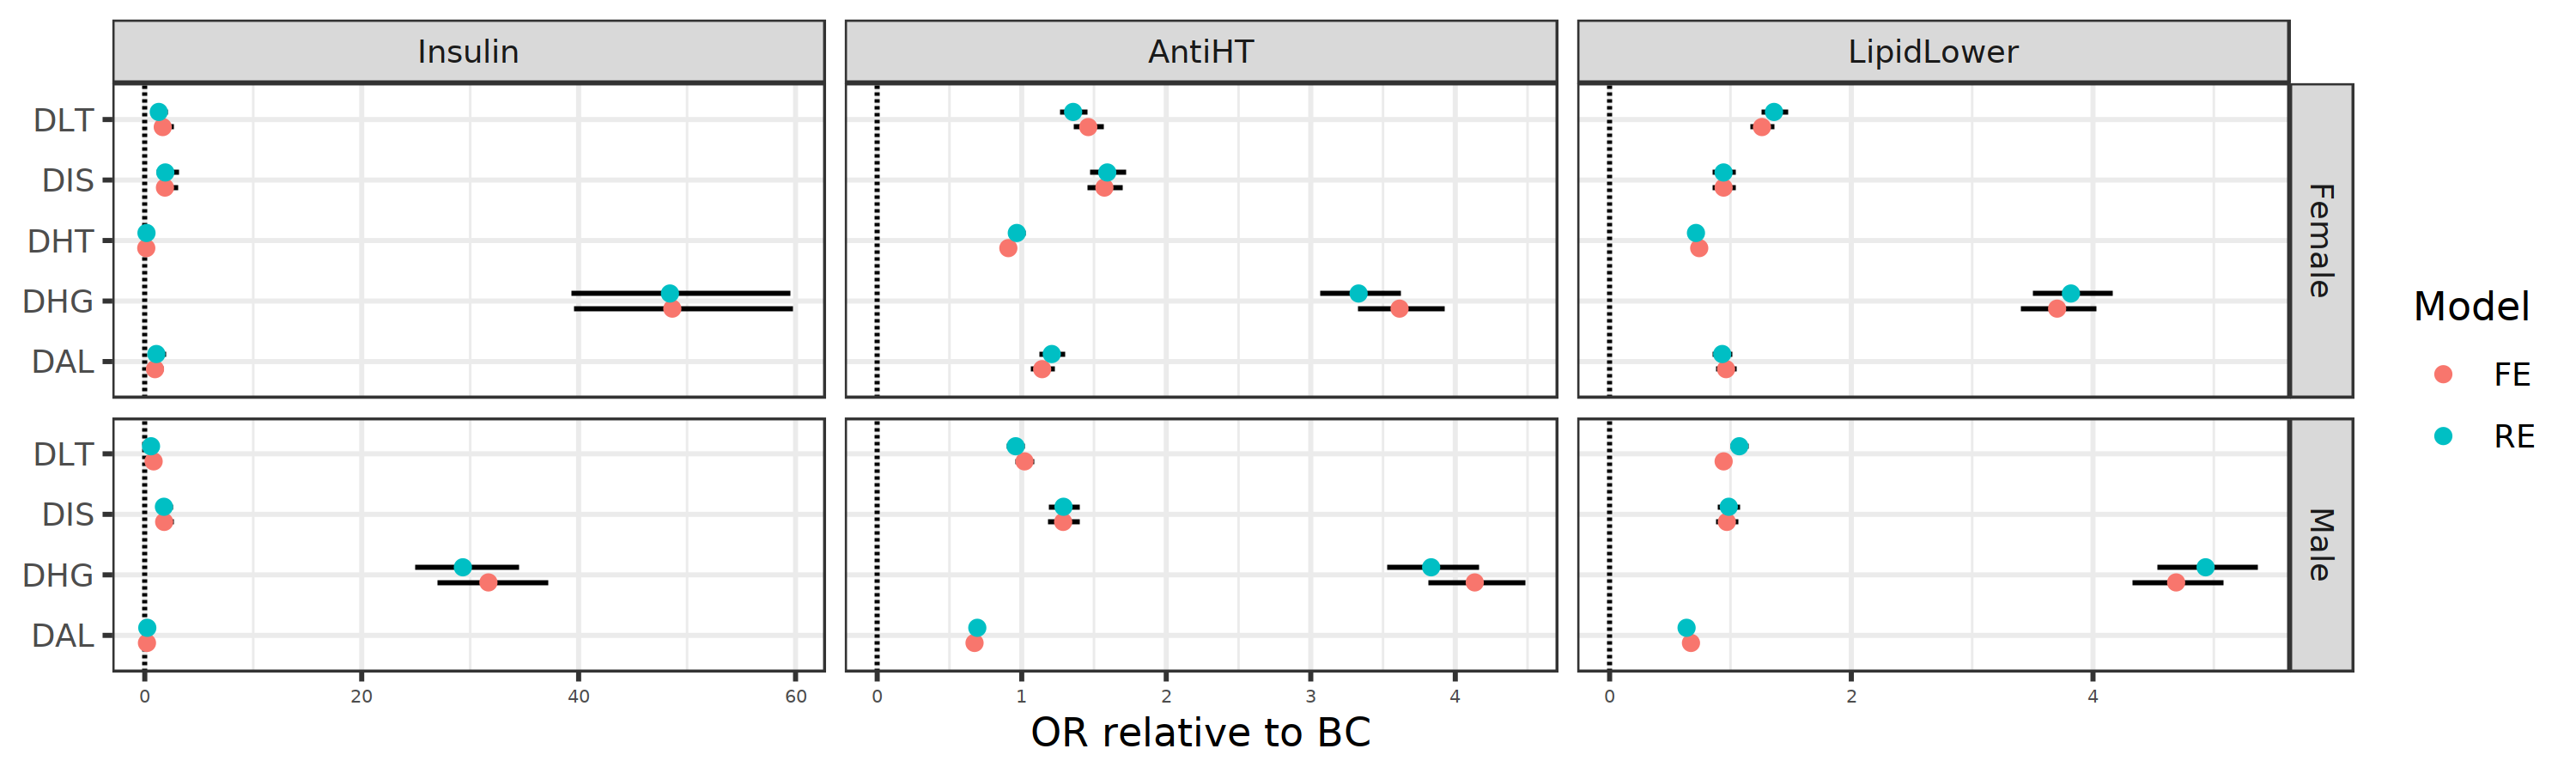

In [79]:
options(repr.plot.width = 10, repr.plot.height = 3)
allORmeds %>%
    drop_na %>%
    filter(cohort %in% c("Pooled_FE", "Pooled_RE")) %>%
    mutate(cohort = gsub("Pooled_", "", cohort)) %>%
    ggplot(aes(OR, Cluster)) +
    geom_vline(xintercept = 0, lty = "dashed") +
    geom_linerange(
        aes(xmin = LOWERCI, xmax = UPPERCI, group = cohort),
        position = position_dodge(width = .5)
    ) +
    geom_point(
        aes(group = cohort, color = cohort),
        position = position_dodge(width = .5)
    ) +
    facet_grid(sex ~ Covariate, scales = "free", space = "free_y") +
    labs(x = "OR relative to BC", y = NULL, color = "Model") +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

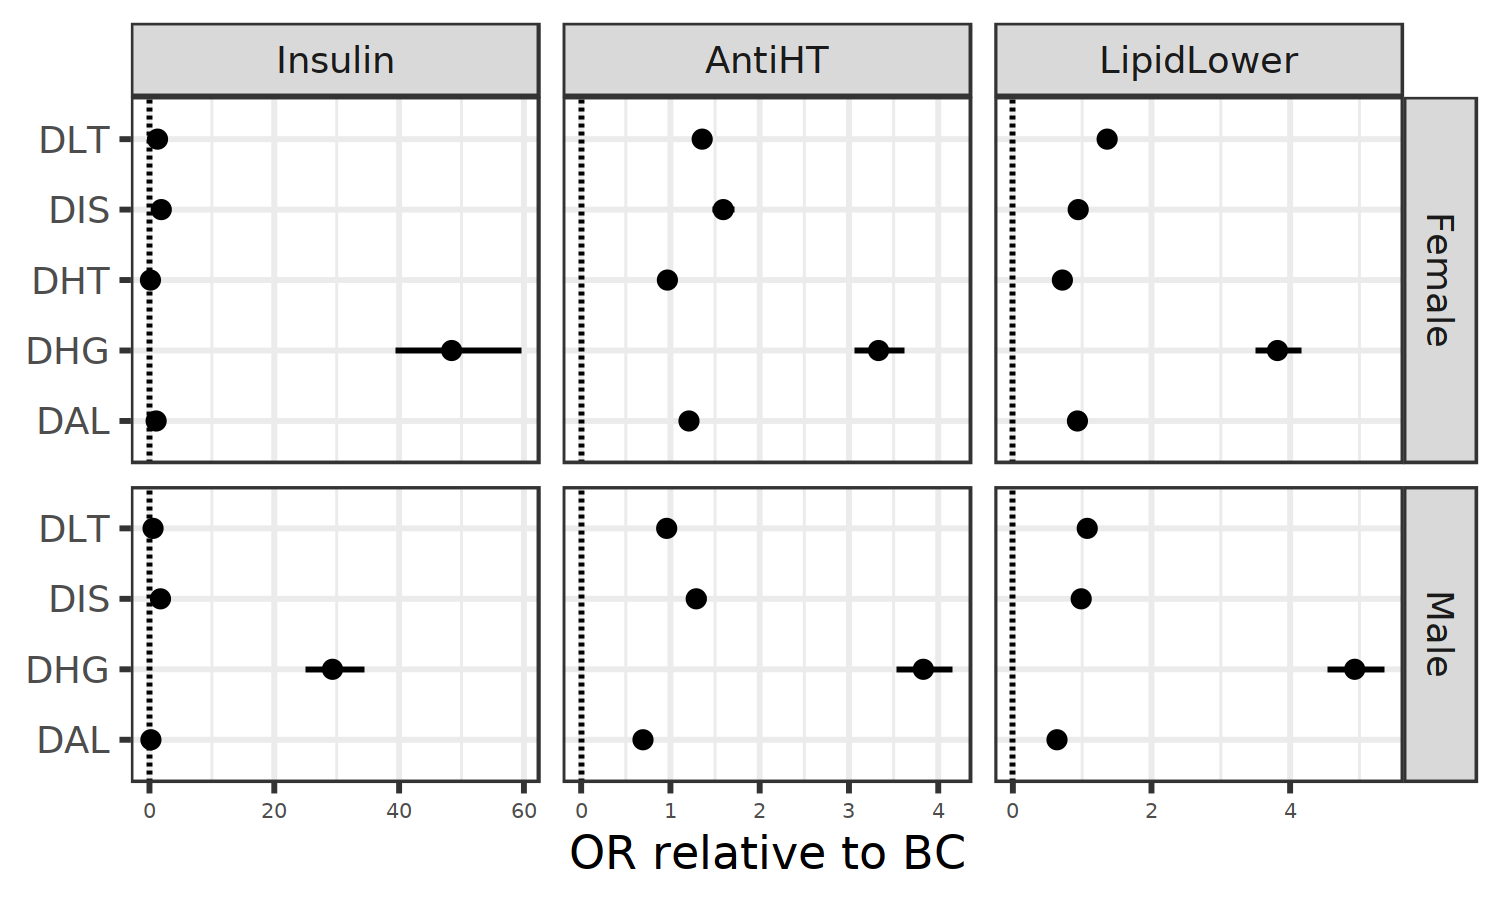

In [83]:
options(repr.plot.width = 5, repr.plot.height = 3)
allORmeds %>%
    drop_na %>%
    filter(cohort == "Pooled_RE") %>%
    ggplot(aes(OR, Cluster)) +
    geom_vline(xintercept = 0, lty = "dashed") +
    geom_linerange(
        aes(xmin = LOWERCI, xmax = UPPERCI)
    ) +
    geom_point() +
    facet_grid(sex ~ Covariate, scales = "free", space = "free_y") +
    labs(x = "OR relative to BC", y = NULL, color = "Model") +
    theme_bw() +
    theme(
        axis.text.x = element_text(size = 5)
    )

## Proportion of people with diseases that are medicated

In [30]:
dxmeddf <- result_crosssect %>%
    filter(element_name %in% c("CountCovars", "CountDXMeds")) %>%
    pivot_wider(names_from = element_name, values_from = element_value) %>%
    mutate(
        CountCovars = map(
            CountCovars, filter, 
            Covariate %in% c("CHD", "Stroke", "T2D")
        ),
        CountCovars = map(
            CountCovars, 
            pivot_longer, c(Ncases, Nnoncases), 
            names_to = "DxStatus", values_to = "DxStatusN"
        ),
        CountDXMeds = map(
            CountDXMeds, filter, 
            Dx %in% c("CHD", "T2D"),
            Med %in% c("NoMed", "AntiHT", "LipidLower")
        ),
        CountDXMeds = map(CountDXMeds, pivot_longer, c(Ncases, Nnoncases), 
                          names_to = "DxStatus", values_to = "DxMedInN"),
        CountDXMeds = map(CountDXMeds, rename, Covariate = Dx),
        joindat = map2(CountCovars, CountDXMeds, inner_join)
    ) %>%
    select(joindat) %>%
    unnest(joindat) %>%
    mutate(
        DxMedOutN = DxStatusN - DxMedInN,
        DxStatus = ifelse(DxStatus == "Ncases", 1, 0),
        across(c(Nclus, DxStatusN), \(x){ NULL })
    )
head(dxmeddf)

Joining with `by = join_by(cohort, sex, Cluster, Covariate, DxStatus)`


cohort,sex,Cluster,Covariate,DxStatus,Med,DxMedInN,DxMedOutN
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
ukb,Female,probBC,CHD,1,NoMed,206.1084,1452.8921
ukb,Female,probBC,CHD,1,AntiHT,1320.0000,339.0005
ukb,Female,probBC,CHD,1,LipidLower,1206.0000,453.0005
ukb,Female,probBC,CHD,0,NoMed,42000.9493,15013.3849
ukb,Female,probBC,CHD,0,AntiHT,10480.0000,46534.3342
ukb,Female,probBC,CHD,0,LipidLower,8573.0000,48441.3342


In [31]:
dxmedmods <- dxmeddf %>%
    nest(D = -c(cohort, sex, Med, Covariate)) %>%
    mutate(
        model = map(D, ~glm(cbind(round(DxMedInN), round(DxMedOutN)) ~ Cluster * DxStatus, data = .x, family = binomial)),
        model = map(model, broom::tidy),
        D = NULL
    ) %>%
    unnest(model) %>%
    filter(term != "(Intercept)") %>%
    mutate(
        OR = exp(estimate),
        LOWERCI = exp(estimate - qnorm(1 - .05/2)*std.error),
        UPPERCI = exp(estimate + qnorm(1 - .05/2)*std.error)
    )
head(dxmedmods)
nrow(dxmedmods)

cohort,sex,Covariate,Med,term,estimate,std.error,statistic,p.value,OR,LOWERCI,UPPERCI
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ukb,Female,CHD,NoMed,ClusterprobDAL,-0.17666692,0.03640735,-4.852507,1.219103e-06,0.83805888,0.78034120,0.9000456
ukb,Female,CHD,NoMed,ClusterprobDHG,-1.29825304,0.05586561,-23.238857,1.843976e-119,0.27300831,0.24469380,0.3045992
ukb,Female,CHD,NoMed,ClusterprobDHT,0.03952729,0.02832742,1.395372,1.629037e-01,1.04031889,0.98413378,1.0997116
ukb,Female,CHD,NoMed,ClusterprobDIS,-0.30870175,0.04262803,-7.241754,4.429175e-13,0.73439978,0.67553443,0.7983946
ukb,Female,CHD,NoMed,ClusterprobDLT,-0.38068486,0.04131871,-9.213376,3.160244e-20,0.68339322,0.63023151,0.7410393
ukb,Female,CHD,NoMed,DxStatus,-2.98228643,0.07505343,-39.735509,0.000000e+00,0.05067683,0.04374454,0.0587077


[1] 480

In [34]:
pooldxmedmods <- dxmeddf %>%
    nest(D = -c(sex, Med, Covariate)) %>%
    mutate(
        Pooled_FE = map(
            D, 
            ~glm(
                cbind(round(DxMedInN), round(DxMedOutN)) ~ Cluster * DxStatus, 
                data = .x, family = binomial
            )
        ),
        Pooled_RE = map(
            D, 
            ~glmer(
                cbind(round(DxMedInN), round(DxMedOutN)) ~ Cluster * DxStatus + (1|cohort), 
                data = .x, family = binomial
            )
        ),
        D = NULL
    ) %>%
    pivot_longer(c(Pooled_FE, Pooled_RE), names_to = "cohort", values_to = "model") %>%
    mutate(
        model = map2(cohort, model, ~if(.x == "Pooled_FE"){ broom::tidy(.y) } else { broom.mixed::tidy(.y) })
    ) %>%
    unnest(model) %>%
    filter(!grepl("(Intercept)", term)) %>%
    select(-c(effect, group)) %>%
    mutate(
        OR = exp(estimate),
        LOWERCI = exp(estimate - qnorm(1 - .05/2)*std.error),
        UPPERCI = exp(estimate + qnorm(1 - .05/2)*std.error),
    )
head(pooldxmedmods)

sex,Covariate,Med,cohort,term,estimate,std.error,statistic,p.value,OR,LOWERCI,UPPERCI
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,CHD,NoMed,Pooled_FE,ClusterprobDAL,-0.1437894,0.03508134,-4.098743,4.154002e-05,0.86607012,0.80852185,0.92771451
Female,CHD,NoMed,Pooled_FE,ClusterprobDHG,-1.5162002,0.04536968,-33.418803,7.310856e-245,0.21954452,0.20086481,0.23996138
Female,CHD,NoMed,Pooled_FE,ClusterprobDHT,0.0761087,0.02737362,2.780367,5.429757e-03,1.07907987,1.02271146,1.13855512
Female,CHD,NoMed,Pooled_FE,ClusterprobDIS,-0.3066349,0.03907686,-7.846969,4.262137e-15,0.73591924,0.68166010,0.79449733
Female,CHD,NoMed,Pooled_FE,ClusterprobDLT,-0.3724163,0.03445593,-10.808483,3.138179e-27,0.68906734,0.64406950,0.73720896
Female,CHD,NoMed,Pooled_FE,DxStatus,-2.9078728,0.06945065,-41.869626,0.000000e+00,0.05459173,0.04764424,0.06255232


In [35]:
alldxmedmods <- pooldxmedmods %>%
    mutate(cohort = "Pooled") %>%
    bind_rows(dxmedmods) %>%
    transmute(
        sex, Covariate, 
        cohort = factor(
            case_match(
                cohort,
                "ukb" ~ "UKB",
                "maastricht" ~ "MAS",
                "rotterdam" ~ "RTD",
                "ghs" ~ "GHS",
                .default = cohort
            ),
            levels = c("UKB", "MAS", "RTD", "GHS", "Pooled_FE", "Pooled_RE")
        ),      
        term = gsub("prob", "", term), 
        across(everything())
    ) %>%
    arrange(sex, Covariate, term, Med, cohort)
head(alldxmedmods)
nrow(alldxmedmods)

sex,Covariate,cohort,term,Med,estimate,std.error,statistic,p.value,OR,LOWERCI,UPPERCI
<chr>,<chr>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Female,CHD,UKB,ClusterDAL,AntiHT,0.22977874,0.04026746,5.70631316,1.154495e-08,1.258322,1.1628292,1.361656
Female,CHD,MAS,ClusterDAL,AntiHT,0.56976430,0.56180731,1.01416321,3.105049e-01,1.767850,0.5878063,5.316879
Female,CHD,RTD,ClusterDAL,AntiHT,0.17787993,0.20134851,0.88344299,3.769970e-01,1.194682,0.8051265,1.772721
Female,CHD,GHS,ClusterDAL,AntiHT,0.02300413,0.23083713,0.09965525,9.206180e-01,1.023271,0.6508811,1.608716
Female,CHD,NA,ClusterDAL,AntiHT,0.15730280,0.03863308,4.07171316,4.666863e-05,1.170350,1.0850037,1.262410
Female,CHD,NA,ClusterDAL,AntiHT,0.22141898,0.03880416,5.70606279,1.156194e-08,1.247846,1.1564607,1.346453


[1] 720

In [36]:
write_tsv(alldxmedmods, "../data/alldxmedmods.tsv")